### Thank you for reviewing.  The multilayer perceptron in sklearn does not lend itself to simple AUC analysis.  Will attempt in keras/tensorflow with softmax output layer to generate more analysis.

# Create a multilayer perceptron classifier to predict TP53 mutation from gene expression data in TCGA

In [1]:
import os
import urllib
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, grid_search
from sklearn.neural_network import MLPClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from statsmodels.robust.scale import mad

/home/ktt/anaconda2/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ktt/anaconda2/envs/cognoma-machine-learning/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
%matplotlib inline
plt.style.use('seaborn-notebook')

*Please look at the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) regarding the hyperparameters and modules of the MLP Classifier*

*Here is some [documentation](http://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron) regarding the implementation and some examples*

*Here is some [information](https://ghr.nlm.nih.gov/gene/TP53) about TP53*

## Load Data

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

In [4]:
url_to_path = {
    # X matrix
    'https://ndownloader.figshare.com/files/5514386':
        os.path.join('data', 'expression.tsv.bz2'),
    # Y Matrix
    'https://ndownloader.figshare.com/files/5514389':
        os.path.join('data', 'mutation-matrix.tsv.bz2'),
}

for url, path in url_to_path.items():
    if not os.path.exists(path):
        urllib.request.urlretrieve(url, path)

In [5]:
%%time
path = os.path.join('data', 'expression.tsv.bz2')
X = pd.read_table(path, index_col=0)

CPU times: user 2min 17s, sys: 204 ms, total: 2min 17s
Wall time: 2min 17s


In [6]:
%%time
X.describe()

CPU times: user 39 s, sys: 100 ms, total: 39.1 s
Wall time: 39.1 s


,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR
count,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,...,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000,7706.000000
mean,6.764302,1.561722,2.003302,6.503915,13.396292,3.823209,8.308523,1.093011,0.340014,9.657346,...,5.553559,8.519716,10.041328,3.682028,9.744062,11.952254,10.164720,9.451930,5.253875,0.376442
std,2.358795,3.050370,2.682042,1.005185,1.489273,4.102231,1.689981,1.548777,0.821027,0.512833,...,0.889469,0.744462,0.451175,2.696282,0.643921,0.927360,0.656587,0.591051,2.560649,1.291098
min,0.962000,0.000000,0.000000,1.730000,8.110000,0.000000,1.890000,0.000000,0.000000,6.340000,...,0.000000,0.709000,7.770000,0.000000,6.260000,7.140000,7.040000,6.680000,0.000000,0.000000
25%,5.292500,0.000000,0.000000,5.960000,12.400000,0.392000,7.070000,0.000000,0.000000,9.330000,...,5.040000,8.080000,9.780000,1.072500,9.340000,11.400000,9.780000,9.110000,3.270000,0.000000
50%,6.550000,0.000000,0.715500,6.560000,13.300000,2.050000,8.310000,0.638500,0.000000,9.620000,...,5.650000,8.540000,10.100000,3.670000,9.750000,12.000000,10.200000,9.490000,4.835000,0.000000
75%,7.667500,0.821000,3.207500,7.120000,14.300000,6.910000,9.560000,1.390000,0.321750,9.950000,...,6.160000,8.980000,10.300000,5.990000,10.200000,12.600000,10.600000,9.827500,7.440000,0.000000
max,19.000000,12.200000,12.600000,11.500000,19.500000,16.700000,13.300000,11.300000,7.940000,12.100000,...,8.430000,12.100000,12.200000,13.100000,14.400000,15.600000,13.000000,13.000000,13.400000,9.440000


In [7]:
%%time
path = os.path.join('data', 'mutation-matrix.tsv.bz2')
Y = pd.read_table(path, index_col=0)

CPU times: user 2min 2s, sys: 1.32 s, total: 2min 3s
Wall time: 2min 3s


In [1]:
# We're going to be building a 'TP53' classifier 
GENE = 'TP53'

In [9]:
y = Y[GENE]

In [10]:
# The Series now holds TP53 Mutation Status for each Sample
y.head(6)

sample_id
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    1
TCGA-02-2485-01    1
TCGA-02-2486-01    0
TCGA-04-1348-01    1
Name: TP53, dtype: int64

In [11]:
# Here are the percentage of tumors with NF1
y.value_counts(True)

0    0.655334
1    0.344666
Name: TP53, dtype: float64

## Specify model configuration

In [12]:
# Parameter Sweep for Hyperparameters
n_feature_kept = 500
param_fixed = {
    'solver': 'adam',
    'random_state' : 0,
    'activation': 'tanh'
}
param_grid = {
    'alpha': [10 ** x for x in range(-5, 3)],
    'learning_rate_init': [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05],
}

## Set aside 10% of the data for testing

In [13]:
# Typically, this can only be done where the number of mutations is large enough
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
'Size: {:,} features, {:,} training samples, {:,} testing samples'.format(len(X.columns), len(X_train), len(X_test))

'Size: 20,501 features, 6,935 training samples, 771 testing samples'

## Median absolute deviation feature selection

In [14]:
def fs_mad(x, y):
    """    
    Get the median absolute deviation (MAD) for each column of x
    """
    scores = mad(x) 
    return scores, np.array([np.NaN]*len(scores))

# select the top features with the highest MAD
feature_select = SelectKBest(fs_mad, k=n_feature_kept)

## Define pipeline and Cross validation model fitting

# NB

Due to my inability to get the 'roc_auc' score to properly chart, will change scoring to 'f1_micro'
Please see [documentation](http://scikit-learn.org/stable/modules/model_evaluation.html)

In [15]:
# Include loss='log' in param_grid doesn't work with pipeline somehow
clf = MLPClassifier(solver=param_fixed['solver'], activation=param_fixed['activation'],
                    hidden_layer_sizes=[64, 8], random_state=param_fixed['random_state'])

# joblib is used to cross-validate in parallel by setting `n_jobs=-1` in GridSearchCV
# Supress joblib warning. See https://github.com/scikit-learn/scikit-learn/issues/6370
warnings.filterwarnings('ignore', message='Changing the shape of non-C contiguous array')
clf_grid = grid_search.GridSearchCV(estimator=clf, param_grid=param_grid, n_jobs=-1, scoring='f1_micro')
pipeline = make_pipeline(
    feature_select,  # Feature selection
    StandardScaler(),  # Feature scaling
    clf_grid)

In [16]:
%%time
# Fit the model (the computationally intensive part)
pipeline.fit(X=X_train, y=y_train)
best_clf = clf_grid.best_estimator_
feature_mask = feature_select.get_support()  # Get a boolean array indicating the selected features

CPU times: user 23.9 s, sys: 3.98 s, total: 27.9 s
Wall time: 5min 27s


In [17]:
clf_grid.best_params_

{'alpha': 0.0001, 'learning_rate_init': 0.0025}

# History of best parameters/testing

In [18]:
# Tanh activation, large network MLP [250, 128, 64]
# {'alpha': 0.01, 'learning_rate_init': 0.05}
# {'alpha': 0.1, 'learning_rate_init': 0.05}

# Add relu and sigmoid activation functions to grid search
# {'activation': 'relu', 'alpha': 0.001, 'learning_rate_init': 0.05}

# Designated relu as sole activation function
# {'alpha': 0.1, 'learning_rate_init': 0.01}

# Change activation to tanh to increase chance of convergence, reduced number of nodes [64, 8]
# {'alpha': 1, 'learning_rate_init': 0.005}

# Change in scoring to F1 micro
# {'alpha': 0.001, 'learning_rate_init': 0.01}

# Expanded parameters for grid search
#{'alpha': 0.0001, 'learning_rate_init': 0.0025}

# Expanded parameters for grid search, again
#{'alpha': 0.0001, 'learning_rate_init': 0.0025}

In [19]:
best_clf

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[64, 8], learning_rate='constant',
       learning_rate_init=0.0025, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

## Visualize hyperparameters performance

In [20]:
def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to 
    a tidy pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

## Process Mutation Matrix

In [21]:
cv_score_df = grid_scores_to_df(clf_grid.grid_scores_)
cv_score_df.head(2)

,alpha,fold,learning_rate_init,score
0,0.00001,0,0.001,0.805015
1,0.00001,1,0.001,0.829944


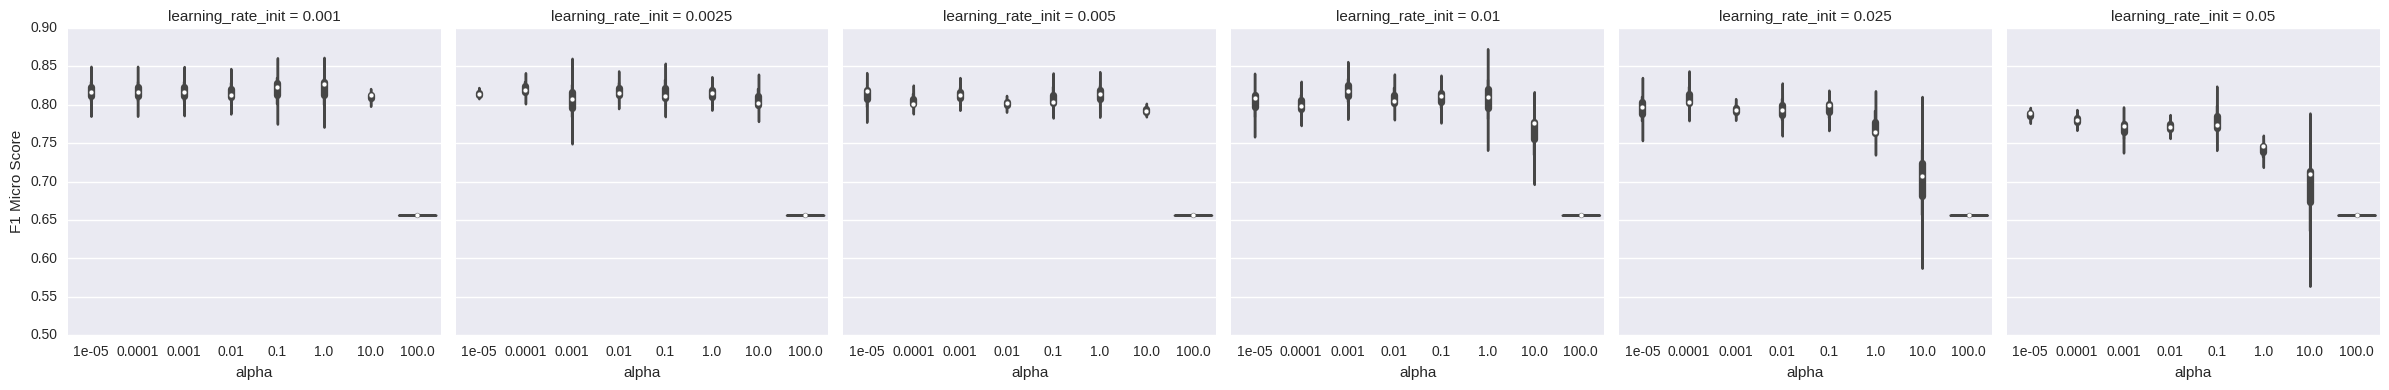

In [22]:
# Cross-validated performance distribution
facet_grid = sns.factorplot(x='alpha', y='score', col='learning_rate_init',
    data=cv_score_df, kind='violin', size=4, aspect=1)
facet_grid.set_ylabels('F1 Micro Score');

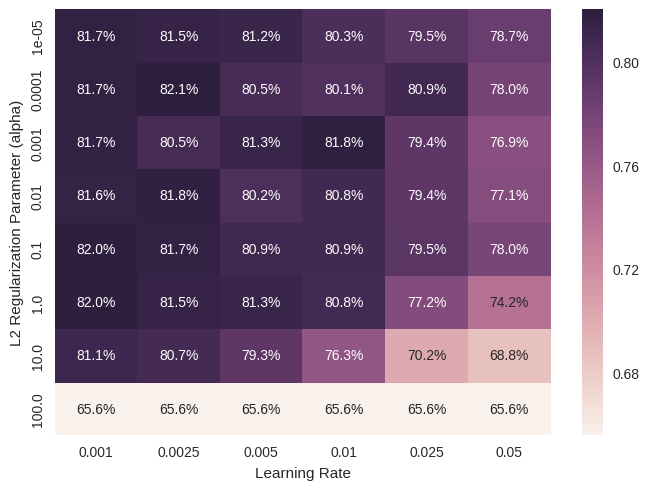

In [23]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_score_df, values='score', index='alpha', columns='learning_rate_init')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Learning Rate')
ax.set_ylabel('L2 Regularization Parameter (alpha)');

# WARNING!
## Errors below!

## Use Optimal Hyperparameters to Output ROC Curve

MLPClassifier has no method called `decision_function()`, so need to use `pipeline.predict()`.

In [24]:
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

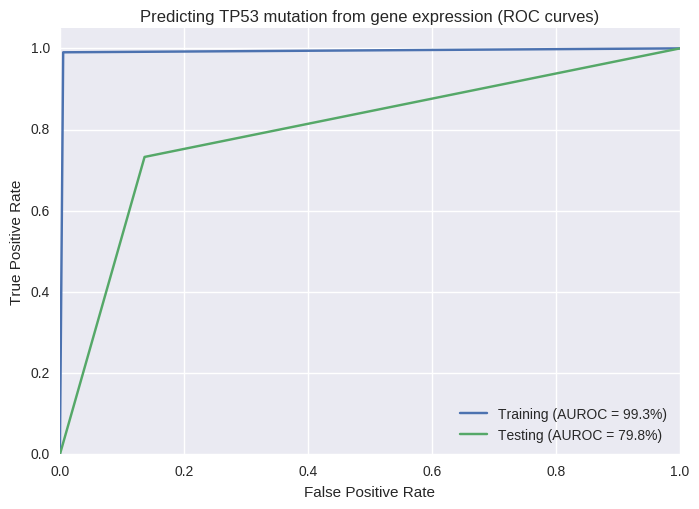

In [25]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

Above does not look right.
Will attempt again with `best_clf.predict()`, `feature_select.transform()`.

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest.transform

In [26]:
y_pred_train = best_clf.predict(feature_select.transform(X_train))
y_pred_test  = best_clf.predict(feature_select.transform(X_test))

def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

metrics_train = get_threshold_metrics(y_train, y_pred_train)
metrics_test = get_threshold_metrics(y_test, y_pred_test)

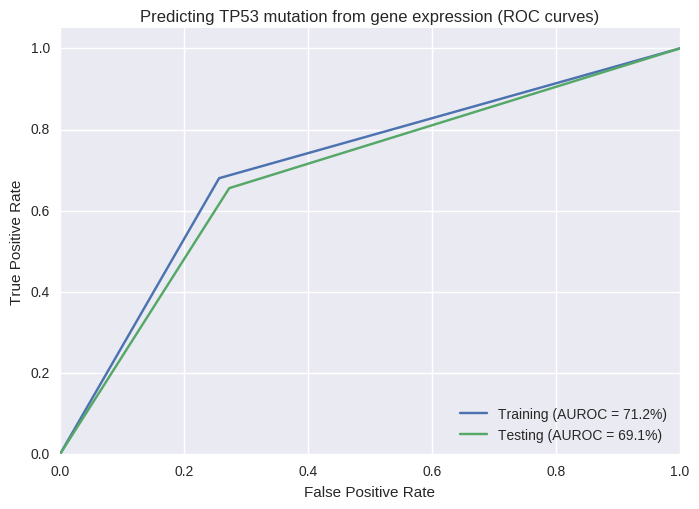

In [27]:
# Plot ROC
plt.figure()
for label, metrics in ('Training', metrics_train), ('Testing', metrics_test):
    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
        label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## What are the classifier coefficients?

In a MLP, the classifier coefficients are not as directly interpretable.

## Investigate the predictions